Implementation of Fully Convolutional Networks for Image Segmantation (FCN) applied to VOCSegmentation dataset trained from scratch. 

Chosen model architecture was FCN-8 as presented in the paper below.

## [Paper](https://arxiv.org/abs/1411.4038)

## Imports

In [1]:
import os
import time
import random

import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as TF

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:0


## Dataset

Download data from official site, define transforms and load images. Torchvision transforms are not applied to the target image, so we define them by hand as done in https://github.com/pytorch/vision/blob/master/references/segmentation/transforms.py



In [2]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = TF.resize(image, self.size)
        target = TF.resize(target, self.size)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = TF.hflip(image)
            target = TF.hflip(target)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = TF.to_tensor(image)
        
        target = np.array(target, dtype=np.float32)
        target = TF.to_tensor(target).long()

        return image, target.squeeze()


In [4]:
train_augmentation = Compose(
    [
        RandomHorizontalFlip(),
        Resize((256, 256)),
        ToTensor(),
    ]
)

test_augmentation = Compose([Resize((256, 256)), ToTensor()])

train_data = VOCSegmentation(
    "sample_data", download=True, transforms=train_augmentation
)
test_data = VOCSegmentation(
    "sample_data", image_set="val", download=True, transforms=test_augmentation
)



Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data
Using downloaded and verified file: sample_data/VOCtrainval_11-May-2012.tar
Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data


## Model

In [5]:
class FCN8Model(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(FCN8Model, self).__init__()
        vgg_layers = torchvision.models.vgg16(pretrained=pretrained).features

        self.backbone = vgg_layers[0:10]
        self.pool3 = vgg_layers[10:17]
        self.pool4 = vgg_layers[17:24]
        self.pool5 = vgg_layers[24:]

        self.up1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512, kernel_size=2, stride=2
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2
        )

        self.prediction = nn.ConvTranspose2d(
            in_channels=256, out_channels=n_classes, kernel_size=8, stride=8
        )

    def forward(self, x):
        # Downsampling
        features = self.backbone(x)
        pool3 = self.pool3(features)
        pool4 = self.pool4(pool3)
        pool5 = self.pool5(pool4)

        # Upsampling and skip connections
        up_pool5 = self.up1(pool5)
        up_features = self.up2(up_pool5 + pool4)
        predictions = self.prediction(up_features + pool3)

        return predictions


## Training

In [6]:
def pixel_accuracy(preds, label):
    probs = torch.log_softmax(preds, dim=1)
    predictions = torch.argmax(probs, dim=1)
    corrects = (predictions == label).float()
    acc = corrects.sum() / corrects.numel()
    
    return acc

def mean_IoU(preds, labels):
    probs = torch.log_softmax(preds, dim=1)
    preds = torch.argmax(probs, dim=1).int()
    labels = labels.int()
    # Taken from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
    intersection = (preds & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (preds | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + 1e-6) / (union + 1e-6)  # We smooth our devision to avoid 0/0

    return iou.mean()


In [7]:
def train_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.train()
    epoch_loss = 0

    for input_images, targets in dataloader:
      optimizer.zero_grad()
      targets = targets.to(device)

      predictions = model(input_images.to(device))
      accuracy = pixel_accuracy(predictions, targets)
      iou = mean_IoU(predictions, targets)

      cost = loss(predictions, targets)
      epoch_loss += cost.item()

      cost.backward()
      optimizer.step()

    return epoch_loss / len(dataloader), accuracy, iou

def test_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
      for input_images, targets in dataloader:
        predictions = model(input_images.to(device))
        targets = targets.to(device)

        accuracy = pixel_accuracy(predictions, targets)
        iou = mean_IoU(predictions, targets)

        cost = loss(predictions, targets)
        epoch_loss += cost.item()

    return epoch_loss / len(dataloader), accuracy, iou


In [8]:
def segmentation_train(
    model,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    epochs=50,
):
    train_loss_hist = []
    train_acc_hist = []
    train_iou_hist = []
    val_loss_hist = []
    val_acc_hist = []
    val_iou_hist = []

    loss_function = nn.CrossEntropyLoss(ignore_index=255).to(device)

    for epoch in range(epochs):
        start = time.time()
        train_loss, train_acc, train_iou = train_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        train_iou_hist.append(train_iou)

        val_loss, val_acc, val_iou = test_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        val_iou_hist.append(val_iou)

        lr_scheduler.step()

        print(
            f"Epoch {epoch + 1} | "
            f"Train Loss {train_loss:.6f} | "
            f"Train pixel accuracy {train_acc:.2f} | "
            f"Train mIoU {train_iou:.3f} | "
            f"Val Loss {val_loss:.6f} | "
            f"Validation pixel accuracy {val_acc:.2f} | "
            f"Validation mIoU {val_iou:.3f} | "
            f"Time {time.time() - start:.2f} sec"
        )
    return (
        train_loss_hist,
        val_loss_hist,
        train_acc_hist,
        val_acc_hist,
        train_iou_hist,
        val_iou_hist,
    )


## Results

In [9]:
PASCAL_VOC_CLASSES = len(VOC_CLASSES)

train_dataloader = DataLoader(
    train_data, batch_size=32, num_workers=2, pin_memory=True
)
val_dataloader = DataLoader(test_data, batch_size=32, num_workers=2, pin_memory=True)

# Define model
fcn_model = FCN8Model(n_classes=PASCAL_VOC_CLASSES, pretrained=True).to(device)

net_optimizer = torch.optim.Adam(fcn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(net_optimizer, step_size=100)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [10]:
N_EPOCHS = 130

train_losses, val_losses, train_acc, val_acc, train_iou, val_iou = segmentation_train(
    fcn_model, net_optimizer, scheduler, train_dataloader, val_dataloader, epochs=N_EPOCHS
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 | Train Loss 1.645900 | Train pixel accuracy 0.61 | Train mIoU 0.000 | Val Loss 1.199275 | Validation pixel accuracy 0.61 | Validation mIoU 0.000 | Time 58.44 sec
Epoch 2 | Train Loss 1.194594 | Train pixel accuracy 0.61 | Train mIoU 0.000 | Val Loss 1.158603 | Validation pixel accuracy 0.61 | Validation mIoU 0.001 | Time 62.69 sec
Epoch 3 | Train Loss 1.134083 | Train pixel accuracy 0.62 | Train mIoU 0.011 | Val Loss 1.092714 | Validation pixel accuracy 0.64 | Validation mIoU 0.038 | Time 63.90 sec
Epoch 4 | Train Loss 1.063277 | Train pixel accuracy 0.62 | Train mIoU 0.016 | Val Loss 1.021399 | Validation pixel accuracy 0.63 | Validation mIoU 0.041 | Time 63.81 sec
Epoch 5 | Train Loss 1.027551 | Train pixel accuracy 0.62 | Train mIoU 0.006 | Val Loss 0.986076 | Validation pixel accuracy 0.63 | Validation mIoU 0.023 | Time 63.86 sec
Epoch 6 | Train Loss 0.983896 | Train pixel accuracy 0.66 | Train mIoU 0.040 | Val Loss 0.950724 | Validation pixel accuracy 0.68 | Validation mI

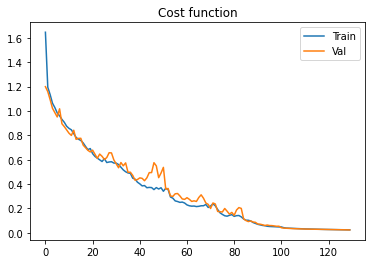

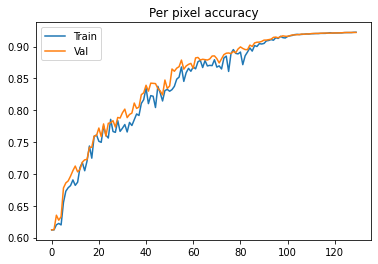

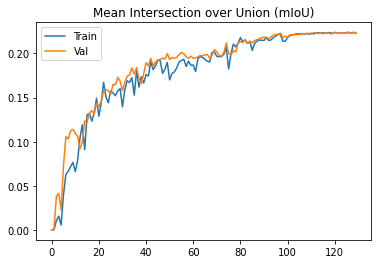

In [11]:
plt.plot(range(N_EPOCHS), train_losses, label="Train")
plt.plot(range(N_EPOCHS), val_losses, label="Val")
plt.legend()
plt.title("Cost function")
plt.show()

plt.plot(range(N_EPOCHS), train_acc, label="Train") 
plt.plot(range(N_EPOCHS), val_acc, label="Val")
plt.legend()
plt.title("Per pixel accuracy")
plt.show()

plt.plot(range(N_EPOCHS), train_iou, label="Train")
plt.plot(range(N_EPOCHS), val_iou, label="Val")
plt.legend()
plt.title("Mean Intersection over Union (mIoU)")
plt.show()

### Visualizations

In [12]:
def mask_to_image(mask):
  VOC_COLORMAP
  image = np.zeros((256, 256, 3))
  for class_idx, colour in enumerate(VOC_COLORMAP):
    image[mask == class_idx, :] = colour

  return image.astype(np.uint8)

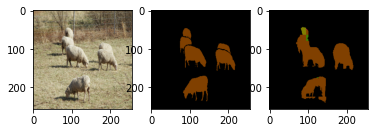

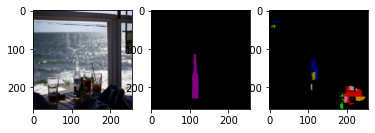

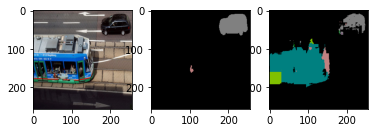

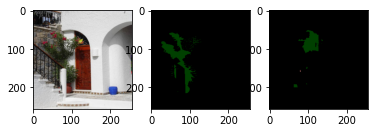

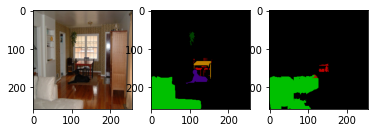

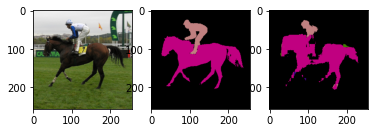

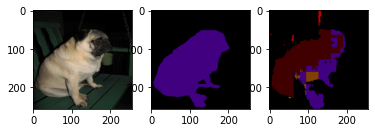

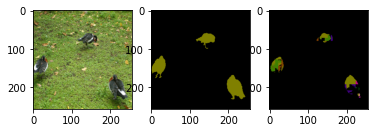

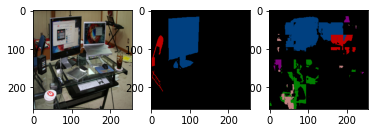

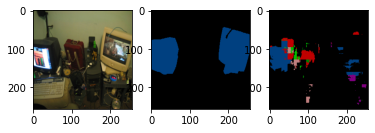

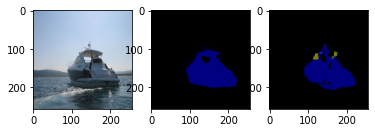

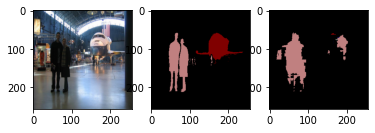

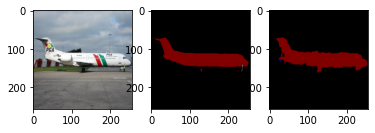

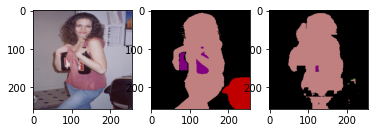

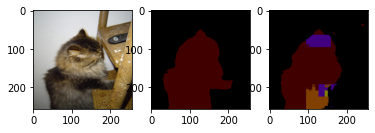

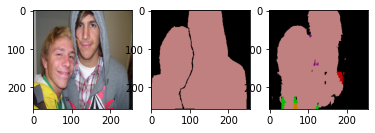

In [13]:
vis_dataloader = DataLoader(test_data, batch_size=16, num_workers=2, shuffle=True)
vis_batch, targets = next(iter(vis_dataloader))

predictions = torch.softmax(fcn_model(vis_batch.to(device)), dim=1)
predictions = torch.argmax(predictions, dim=1)


for idx, image in enumerate(vis_batch):
  fig, axes = plt.subplots(nrows=1, ncols=3)
  axes[0].imshow(image.cpu().numpy().transpose(1, 2, 0))
  axes[1].imshow(mask_to_image(targets[idx]))
  axes[2].imshow(mask_to_image(predictions[idx].cpu()))
